In [263]:
import numpy as np
import matplotlib
matplotlib.use(backend="TkAgg")
import matplotlib.pyplot as plt
import pyart
from pathlib import Path
import radarIQ
from radarIQ.viz.polarGridPlotting import rangeRings, azimuthSpiderweb
from radarIQ.viz import iSpectrumDealias, savedSpectrumDealias
import pickle

plt.rcParams['figure.facecolor'] = '#f1f0e9'
plt.rcParams['axes.facecolor'] = '#f1f0e9'

root = Path().cwd()

In [264]:
cfTime = 79
sampDeg = 0.5
beamOverlap = 0
t = radarIQ.io.raxpolrkc.staticCfradNum2RkcNum(root, 'may232024', cfTime, sampDeg, beamOverlap)
startCfrad = radarIQ.io.raxpolrkc.staticGetExistingCfrad(root, 'may232024', t, sampDeg, beamOverlap)
radar = pyart.io.read(startCfrad)
az_vals = np.arange(0., 360., sampDeg)
range_vals = radar.range['data']
range_vals_km = range_vals/1000

In [265]:
print(startCfrad)

e:\py\cases\may232024\out\s0.5o0\cfrad.RAXPOL-20240524-003427.202.nc


In [266]:
print(t)

120


In [267]:
%matplotlib tk

disp = radarIQ.viz.iPyart(startCfrad.parent, cfTime)

In [268]:
meso_center = {
    'r_km': None,
    'az': None,
    'x': None,
    'y': None
}
spectrum_range = {
    'az': None,
    'ranges': [None, None]
}
unfoldSaveData = None

NFT = None
B = 20
K = 1
K_offset = 'low'
dpsd_strat = 'r'

In [269]:
#stovepipe inflow side
# cfTime = 79
# meso_center = {'r_km': 9.090000361204147, 'az': 34.5, 'x': 5.148632898235013, 'y': 7.49130735225192}
# spectrum_range = {'az': 29.0, 'ranges': [7.965, 11.205]}
# with open(root/"cases"/"may232024"/"unfoldSaveData"/"stovepipeInflowSide.bin", 'rb') as f:
#         unfoldSaveData = pickle.load(f)

# NFT = None
# B = 20
# K = 2
# K_offset = 'low'
# dpsd_strat = 'r'

In [270]:
#stovepipe outflow side
# cfTime = 79
# meso_center = {'r_km': 9.105000361800194, 'az': 34.0, 'x': 5.09145158841725, 'y': 7.548387398059609}
# spectrum_range = {'az': 38.5, 'ranges': [6.975, 11.895]}
# with open(root/"cases"/"may232024"/"unfoldSaveData"/"stovepipeOutflowSide.bin", 'rb') as f:
#         unfoldSaveData = pickle.load(f)

# NFT = None
# B = 20
# K = 2
# K_offset = 'low'
# dpsd_strat = 'r'

In [271]:
#stovepipe center
cfTime = 79
meso_center = {'r_km': 9.090000361204147, 'az': 34.0, 'x': 5.083063694531885, 'y': 7.535951833977139}
spectrum_range = {'az': 34.0, 'ranges': [7.845, 10.425]}
with open(root/"cases"/"may232024"/"unfoldSaveData"/"centerstovepipe.bin", 'rb') as f:
        unfoldSaveData = pickle.load(f)

NFT = None
swathDeg = None
B = 100
K = 1
K_offset = 'low'
dpsd_strat = 'az'

In [272]:
#2 deg dbl fold
# cfTime = 42
# meso_center = {'r_km': 4.320000171661377, 'az': 347.5, 'x': -0.9350191693669263, 'y': 4.217598918350429}
# spectrum_range = {'az': 343.0, 'ranges': [2.565, 6.075], 'iaz': 56, 'iranges': [85, 202]}
# with open(root/"cases"/"may232024"/"unfoldSaveData"/"2degDblFold.bin", 'rb') as f:
#         unfoldSaveData = pickle.load(f)

In [273]:
#0 deg dbl fold
# cfTime = 39
# meso_center = {'r_km': 4.1700001657009125, 'az': 340.5, 'x': -1.3919746583169272, 'y': 3.930815174050939}
# spectrum_range = {'az': 336.5, 'ranges': [3.165, 6.885]}
# with open(root/"cases"/"may232024"/"unfoldSaveData"/"folded0degdblfold.bin", 'rb') as f:
#         unfoldSaveData = pickle.load(f)

In [274]:
def dblclick(event):
    if event.dblclick:
        global t
        x = event.xdata
        y = event.ydata
        if meso_center['r_km'] is None:
            r_km, az = radarIQ.misc.coordConvert.cart2polar(x,y)
            iaz = np.argmin(np.abs(az_vals - az))
            az = az_vals[iaz]

            dr_km = range_vals_km[1]-range_vals_km[0]
            r_km = (dr_km/2) * round(r_km / (dr_km/2))

            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(r_km, az)

            disp.plot(('scatter', plt_x, plt_y, 'b'))

            meso_center['r_km'] = r_km
            meso_center['az'] = az
            meso_center['x'] = plt_x
            meso_center['y'] = plt_y
            disp.setCustomTitle("Doubleclick to set spectrum azimuth.")
        elif spectrum_range['az'] is None:
            _, az = radarIQ.misc.coordConvert.cart2polar(x,y)
            
            d_az = np.abs(az_vals - az)
            iaz = np.argmin(d_az)

            endx, endy = radarIQ.misc.coordConvert.polar2cart(range_vals_km[-1], az_vals[iaz])
            plt_x = [0, endx]
            plt_y = [0, endy]

            disp.plot(('plot', plt_x, plt_y, 'r'))

            spectrum_range['az'] = az_vals[iaz]
            disp.setCustomTitle("Doubleclick to set spectrum range bound.")
        elif spectrum_range['ranges'][0] is None:
            r_km, _ = radarIQ.misc.coordConvert.cart2polar(x,y)

            dr_km = np.abs(range_vals_km - r_km)
            irange = np.argmin(dr_km)
            
            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(range_vals_km[irange], spectrum_range['az'])

            disp.plot(('scatter', plt_x, plt_y, 'g'))

            spectrum_range['ranges'][0] = range_vals_km[irange]
            disp.setCustomTitle("Doubleclick to set other spectrum range bound.")
        elif spectrum_range['ranges'][1] is None:
            r_km, _ = radarIQ.misc.coordConvert.cart2polar(x,y)

            dr_km = np.abs(range_vals_km - r_km)
            irange = np.argmin(dr_km)

            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(range_vals_km[irange], spectrum_range['az'])

            disp.plot(('scatter', plt_x, plt_y, 'g'))

            spectrum_range['ranges'][1] = range_vals_km[irange]
            spectrum_range['ranges'].sort()

            xstart, ystart = radarIQ.misc.coordConvert.polar2cart(spectrum_range['ranges'][0], spectrum_range['az'])
            xend, yend = radarIQ.misc.coordConvert.polar2cart(spectrum_range['ranges'][1], spectrum_range['az'])
            plt_x = [xstart, xend]
            plt_y = [ystart, yend]

            disp.plot(('plot', plt_x, plt_y, 'g'))
            disp.setCustomTitle("Doubleclick to confirm selection.")
        else:
            t = disp.getFileNum()
            t = radarIQ.io.raxpolrkc.staticCfradNum2RkcNum(root, 'may232024', t, sampDeg, beamOverlap)
            plt.close()
disp.addCustomHandler('button_press_event', dblclick)
disp.setCustomTitle("Doubleclick to set mesocyclone centerpoint.")

In [275]:
if spectrum_range['ranges'][1] is None:
    disp.open()

In [276]:
print("cfTime =", disp.curFileNum)
print("meso_center =", meso_center)
print("spectrum_range =", spectrum_range)

cfTime = 79
meso_center = {'r_km': 9.090000361204147, 'az': 34.0, 'x': 5.083063694531885, 'y': 7.535951833977139}
spectrum_range = {'az': 34.0, 'ranges': [7.845, 10.425]}


In [277]:
cfradPath = radarIQ.io.raxpolrkc.staticGetExistingCfrad(root, 'may232024', t, sampDeg, beamOverlap)
dealiasPath = cfradPath.parent/"dealias"/cfradPath.name
if dealiasPath.exists():
    pltRadar = pyart.io.read(dealiasPath)
    dealias_exist = True
else:
    pltRadar = pyart.io.read(cfradPath)
    dealias_exist = False
radar = pyart.io.read(cfradPath)

In [278]:
az_vals = radar.azimuth['data']
range_vals = radar.range['data']
range_vals_km = range_vals/1000

spectrum_range['iaz'] = np.argmin(np.abs(az_vals - spectrum_range['az']))
spectrum_range['iranges'] = []
spectrum_range['iranges'].append(np.argmin(np.abs(range_vals_km - spectrum_range['ranges'][0])))
spectrum_range['iranges'].append(np.argmin(np.abs(range_vals_km - spectrum_range['ranges'][1])))

In [279]:
from datetime import datetime
time = datetime.fromisoformat(radar.metadata['start_datetime'])
timeStr = time.strftime('%m/%d/%Y %H:%M Z')

In [280]:
from netCDF4 import Dataset
data = radarIQ.io.raxpolrkc(root, 'may232024', t)
data.filterBadData()
dataset = Dataset(data.getExistingCfrad(sampDeg, beamOverlap))
boundaries = dataset['pulse_boundaries'][:]
dataset.close()

Filename: e:\py\..\may232024\RAXPOL-20240524-003427.202.rkc
preface = RadarKit/IQ   buildNo = 7
Pulse data size: 1383739616
gateCount = 12458   capacity = 36000   downSampledGateCount = 1246
data offset = 4792
Reading pulses ...
Number of pulses: 68747


In [281]:
pulses = data.pulses
    
az = pulses['azimuthDegrees']
el = pulses['elevationDegrees']

pulses = pulses['iq'].transpose((1,2,3,0))
pulses = pulses[0,:,:,:] + 1.j*pulses[1,:,:,:]
pulses = pulses.transpose((0,2,1)).astype(np.complex128)

c = 299792458.0

ng = pulses.shape[0]
ns = pulses.shape[1]
gstep = 1

wavelength = data.header['desc']['wavelength']
prf_hz = round(1/data.header['config']['prt'])

if data.header['buildNo'] >= 4:
    if data.header['dataType'] == 'raw':
        dr = data.header['config']['pulseGateSize']
        dt = dr * 2 / (c/1e6)
    elif data.header['dataType'] == 'compressed':
        dr = data.header['desc']['pulseToRayRatio'] * data.header['config']['pulseGateSize']
        dt = dr * 2 / (c/1e6)
    else:
        print("Inconsistency detected. This should not happen.")
        dr = 30.
        dt = 1./50
else:
    dr = 30.
    dt = 1./50

va = wavelength * 0.25 * prf_hz

iqh = pulses[:,:,0]
iqv = pulses[:,:,1]

N0 = {
    'H': data.header['config']['noise'][0],
    'V': data.header['config']['noise'][1]
}

In [282]:
if K % 2 == 1:
    K_offset = 0
else:
    if K_offset == 'low':
        K_offset = 0
    elif K_offset == 'high':
        K_offset = 1
    else:
        raise ValueError("Valid values for K_offset: {'low', 'high'}")

In [283]:
if np.mean(np.sign(np.diff(az_vals))) > 0:
    az_set_idx = np.arange(0, K, 1)-(K//2-K_offset)+spectrum_range['iaz']
else:
    az_set_idx = np.arange(K-1, -1, -1)-int(np.ceil(K/2)-np.abs(K_offset-1))+spectrum_range['iaz']
    
az_vals[az_set_idx]

masked_array(data=[34.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [284]:
NR = spectrum_range['iranges'][1]+1-spectrum_range['iranges'][0]

if K > 1:
    if dpsd_strat == 'r':
        ray_boundaries = boundaries[spectrum_range['iaz']]
        NAz = ray_boundaries[1]-ray_boundaries[0]+1
        tV = {
            'H': np.full((K*NR, NAz), fill_value=np.nan + np.nan *1j, dtype=iqh.dtype),
            'V': np.full((K*NR, NAz), fill_value=np.nan + np.nan *1j, dtype=iqv.dtype)
        }
        for i in range(NR):
            iK = np.arange(0, K, 1) + (i)*K
            r_set_idx = np.arange(0, K, 1)+i-(K//2-K_offset)+spectrum_range['iranges'][0]
            r_set_idx[r_set_idx < 0] = 0
            r_set_idx[r_set_idx > (ng-1)] = ng-1
            
            tV['H'][iK,:] = iqh[r_set_idx,ray_boundaries[0]:ray_boundaries[1]+1]
            tV['V'][iK,:] = iqv[r_set_idx,ray_boundaries[0]:ray_boundaries[1]+1]
            
    elif dpsd_strat == 'az':
        if np.mean(np.sign(np.diff(az_vals))) > 0:
            az_set_idx = np.arange(0, K, 1)-(K//2-K_offset)+spectrum_range['iaz']
        else:
            az_set_idx = np.arange(K-1, -1, -1)-int(np.ceil(K/2)-np.abs(K_offset-1))+spectrum_range['iaz']
        if np.any(az_set_idx < 0) or np.any(az_set_idx >= len(az_vals)):
            raise ValueError("Some azimuths being averaged over do not exist. Lower K or move target azimuth away from edge.")
        
        ray_boundaries = boundaries[az_set_idx]
        NAz = np.min(np.diff(ray_boundaries))+1
        tV = {
            'H': np.full((K*NR, NAz), fill_value=np.nan + np.nan *1j, dtype=iqh.dtype),
            'V': np.full((K*NR, NAz), fill_value=np.nan + np.nan *1j, dtype=iqv.dtype)
        }
        
        iK = 0
        for i in range(NR):
            for pulse in ray_boundaries[:,0]:
                tV['H'][iK,:] = iqh[i+spectrum_range['iranges'][0],pulse:pulse+NAz]
                tV['V'][iK,:] = iqv[i+spectrum_range['iranges'][0],pulse:pulse+NAz]
                iK+=1
        
        
else:
    ray_boundaries = boundaries[spectrum_range['iaz']]
    NAz = ray_boundaries[1]-ray_boundaries[0]+1
    tV = {
        'H': iqh[spectrum_range['iranges'][0]:spectrum_range['iranges'][1]+1,ray_boundaries[0]:ray_boundaries[1]+1],
        'V': iqv[spectrum_range['iranges'][0]:spectrum_range['iranges'][1]+1,ray_boundaries[0]:ray_boundaries[1]+1]
    }
w = np.blackman(NAz)

In [285]:
E = radarIQ.proc.bootstrapDPSD(tV, w, N0, None, B, K, NR)
#unfoldSaveData = None

In [286]:
E['sR'].shape

(87, 324)

In [287]:
href = 10*np.log10(E['sS']['H'])
vref = 10*np.log10(E['sS']['V'])
snrh = 10*np.log10(E['sSNR']['H'])
snrv = 10*np.log10(E['sSNR']['V'])
ZDR = 10*np.log10(E['sD']) + data.header['config']['systemDCal']
rhoHV = np.array(E['sR'])

maskval = 20
mask = (snrh > maskval)

snrh[~mask] = np.nan
snrv[~mask] = np.nan
ZDR[~mask] = np.nan
rhoHV[~mask] = np.nan
href[~mask] = np.nan
vref[~mask] = np.nan

In [288]:
%matplotlib tk
if unfoldSaveData is None:
    fields, x_axis, unfoldSaveData = iSpectrumDealias([snrh, snrv, ZDR, rhoHV, href, vref], va)
    with open(data.casePath/"unfoldSaveData"/"latestSpectraUnfold.bin", 'wb') as f:
        pickle.dump(unfoldSaveData, f)
else:
    fields, x_axis = savedSpectrumDealias([snrh, snrv, ZDR, rhoHV, href, vref], va, unfoldSaveData)
snrh = fields[0]
snrv = fields[1]
ZDR = fields[2]
rhoHV = fields[3]
href = fields[4]
vref = fields[5]

In [289]:
imgDir = data.casePath/"img"
imgDir

WindowsPath('e:/py/cases/may232024/img')

In [290]:
#0 = no lines
#1 = lines in PPI but not in spectra
#2 = lines in both PPI and Spectra
line = 2

c:\Users\ameya\miniforge3\envs\weather\lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\ameya\miniforge3\envs\weather\lib\site-packages\pyart\graph\radardisplay.py:99: UserWarning: RadarDisplay does not correct for moving platforms
  warnings.warn("RadarDisplay does not correct for moving platforms")


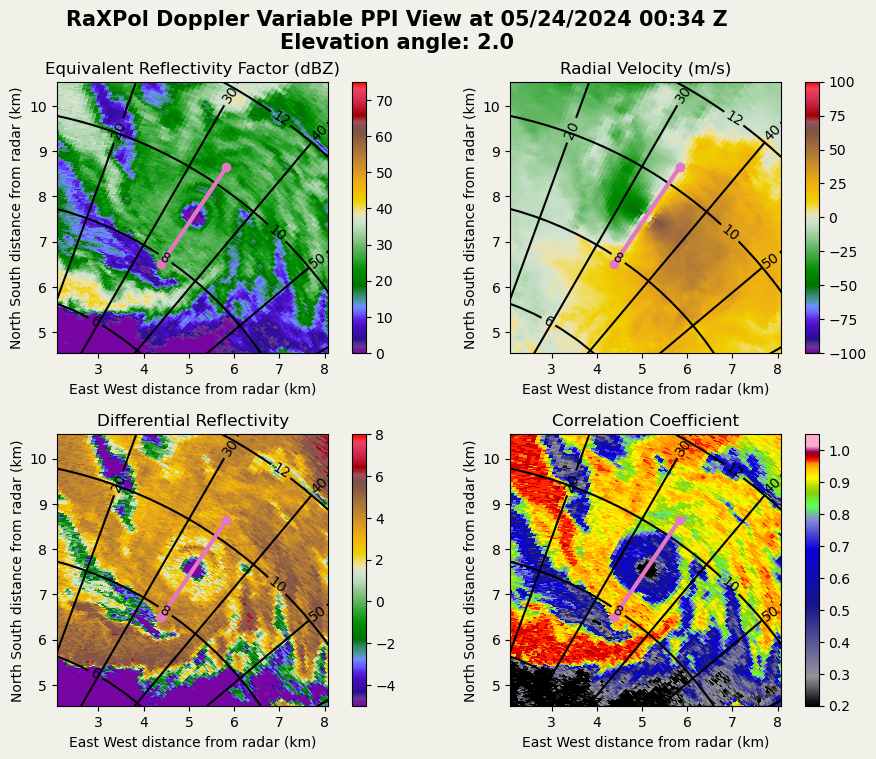

In [291]:
%matplotlib inline
tilt = radar.fixed_angle["data"][0]
display = pyart.graph.RadarDisplay(pltRadar)
fields_to_plot = {
    'DBZ': {
        'ranges': (0, 75),
        'cmap': 'pyart_Carbone42',
        'title': 'Equivalent Reflectivity Factor (dBZ)'
    },
    'VEL': {
        'ranges': (-radar.get_nyquist_vel(0), radar.get_nyquist_vel(0)),
        'cmap': 'pyart_Carbone42',
        'title': 'Folded Radial Velocity (m/s)'
    },
    'CORVEL': {
        'ranges': (-100, 100),
        'cmap': 'pyart_Carbone42',
        'title': 'Radial Velocity (m/s)'
    },
    'ZDR': {
        'ranges': (-5, 8),
        'cmap': 'pyart_Carbone42',
        'title': 'Differential Reflectivity'
    },
    'RHOHV': {
        'ranges': (0.2, 1.05),
        'cmap': radarIQ.viz.cmaps.rmap(256),
        'title': 'Correlation Coefficient'
    } 
}

if dealias_exist:
    del fields_to_plot["VEL"]
else:
    del fields_to_plot["CORVEL"]
    
xstart, ystart = radarIQ.misc.coordConvert.polar2cart(range_vals_km[spectrum_range['iranges'][0]], az_vals[spectrum_range['iaz']])
xend, yend = radarIQ.misc.coordConvert.polar2cart(range_vals_km[spectrum_range['iranges'][1]], az_vals[spectrum_range['iaz']])
plt_x = [xstart, xend]
plt_y = [ystart, yend]

half_plot_size = np.ceil(np.abs(np.array(
    [xstart-meso_center['x'], xend-meso_center['x'], ystart-meso_center['y'], yend-meso_center['y']]
)).max()) + 1

xlim = (meso_center['x']-half_plot_size, meso_center['x']+half_plot_size)
ylim = (meso_center['y']-half_plot_size, meso_center['y']+half_plot_size)

xmax = max([abs(i) for i in xlim])
ymax = max([abs(i) for i in ylim])

maxR = np.sqrt(xmax**2 + ymax**2)

plt.figure(figsize=[12, 8])

for plot_num, field in enumerate(fields_to_plot.keys()):
    vmin, vmax = fields_to_plot[field]['ranges']
    cmap = fields_to_plot[field]['cmap']

    plt.subplot(2, 2, plot_num+1)
    plt.axis('scaled')
    display.plot_ppi(field, vmin=vmin, vmax=vmax, cmap=cmap, title_flag=False)
    display.set_limits(xlim=xlim, ylim=ylim)
    display.cbs[plot_num].set_label('')
    plt.title(fields_to_plot[field]['title'])

    rangeRings(rint=2, maxR=maxR, xlims=xlim, ylims=ylim)
    azimuthSpiderweb(azint=10, maxR=maxR, xlims=xlim, ylims=ylim, n=500)

    #line
    if line >= 1:
        plt.scatter(plt_x, plt_y, color='tab:pink')
        plt.plot(plt_x, plt_y, color='tab:pink', linewidth=3)

plt.subplots_adjust(top=0.89, wspace=-0.05, hspace=0.3)
plt.suptitle('RaXPol Doppler Variable PPI View at ' + timeStr + 
             '\nElevation angle: ' + str(round(tilt, 2)) , weight='bold', fontsize=15)
plt.savefig(imgDir/'ppi.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

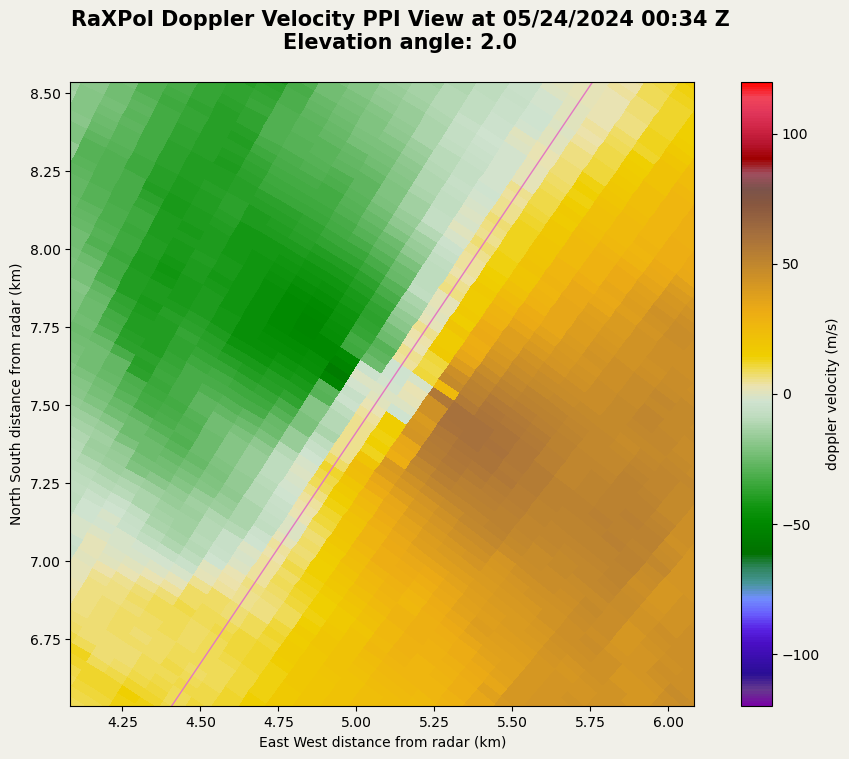

In [292]:
%matplotlib inline
tilt = radar.fixed_angle["data"][0]
display = pyart.graph.RadarDisplay(pltRadar)
fields_to_plot = {
    'VEL': {
        'ranges': (-radar.get_nyquist_vel(0), radar.get_nyquist_vel(0)),
        'cmap': 'pyart_Carbone42',
        'title': 'Folded Radial Velocity (m/s)'
    },
    'CORVEL': {
        'ranges': (-120, 120),
        'cmap': 'pyart_Carbone42',
        'title': 'Radial Velocity (m/s)'
    },
}

if dealias_exist:
    del fields_to_plot["VEL"]
else:
    del fields_to_plot["CORVEL"]
    
xstart, ystart = radarIQ.misc.coordConvert.polar2cart(range_vals_km[spectrum_range['iranges'][0]], az_vals[spectrum_range['iaz']])
xend, yend = radarIQ.misc.coordConvert.polar2cart(range_vals_km[spectrum_range['iranges'][1]], az_vals[spectrum_range['iaz']])
plt_x = [xstart, xend]
plt_y = [ystart, yend]

half_plot_size = np.ceil(np.abs(np.array(
    [xstart-meso_center['x'], xend-meso_center['x'], ystart-meso_center['y'], yend-meso_center['y']]
)).max()) + -1

xlim = (meso_center['x']-half_plot_size, meso_center['x']+half_plot_size)
ylim = (meso_center['y']-half_plot_size, meso_center['y']+half_plot_size)

xmax = max([abs(i) for i in xlim])
ymax = max([abs(i) for i in ylim])

maxR = np.sqrt(xmax**2 + ymax**2)

plt.figure(figsize=[12, 8])

for plot_num, field in enumerate(fields_to_plot.keys()):
    vmin, vmax = fields_to_plot[field]['ranges']
    cmap = fields_to_plot[field]['cmap']

    plt.subplot(1, 1, plot_num+1)
    plt.axis('scaled')
    display.plot_ppi(field, vmin=vmin, vmax=vmax, cmap=cmap, title_flag=False)
    display.set_limits(xlim=xlim, ylim=ylim)
    #display.cbs[plot_num].set_label('')
    #plt.title(fields_to_plot[field]['title'])

    # rangeRings(rint=2, maxR=maxR, xlims=xlim, ylims=ylim)
    # azimuthSpiderweb(azint=10, maxR=maxR, xlims=xlim, ylims=ylim, n=500)

    #line
    if line >= 1:
        plt.scatter(plt_x, plt_y, color='tab:pink')
        plt.plot(plt_x, plt_y, color='tab:pink', linewidth=1)

plt.subplots_adjust(top=0.89, wspace=-0.05, hspace=0.3)
plt.suptitle('RaXPol Doppler Velocity PPI View at ' + timeStr + 
             '\nElevation angle: ' + str(round(tilt, 2)) , weight='bold', fontsize=15)
plt.savefig(imgDir/'ppi.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [293]:
spectrum_range

{'az': 34.0, 'ranges': [7.845, 10.425], 'iaz': 74, 'iranges': [261, 347]}

In [294]:
vel = pltRadar.fields["VEL"]["data"][spectrum_range["iaz"], spectrum_range["iranges"][0]:spectrum_range["iranges"][1]+1]
#corvel = pltRadar.fields["CORVEL"]["data"][spectrum_range["iaz"], spectrum_range["iranges"][0]:spectrum_range["iranges"][1]+1]

In [295]:
r_unique = range_vals_km[spectrum_range["iranges"][0]:spectrum_range["iranges"][1]+1]

In [296]:
#stovepipe outflow side
# r_single = 9.45
# r_single = 5
# r_single = 8.75

In [297]:
#center stovepipe
# r_single = 8.505
r_single = 8.595
#r_single = 8.625

In [298]:
#2deg dbl fold
# r_single = 9.45
# r_single = 4.335
# r_single = 4.185

In [299]:
#r_single = 5.055

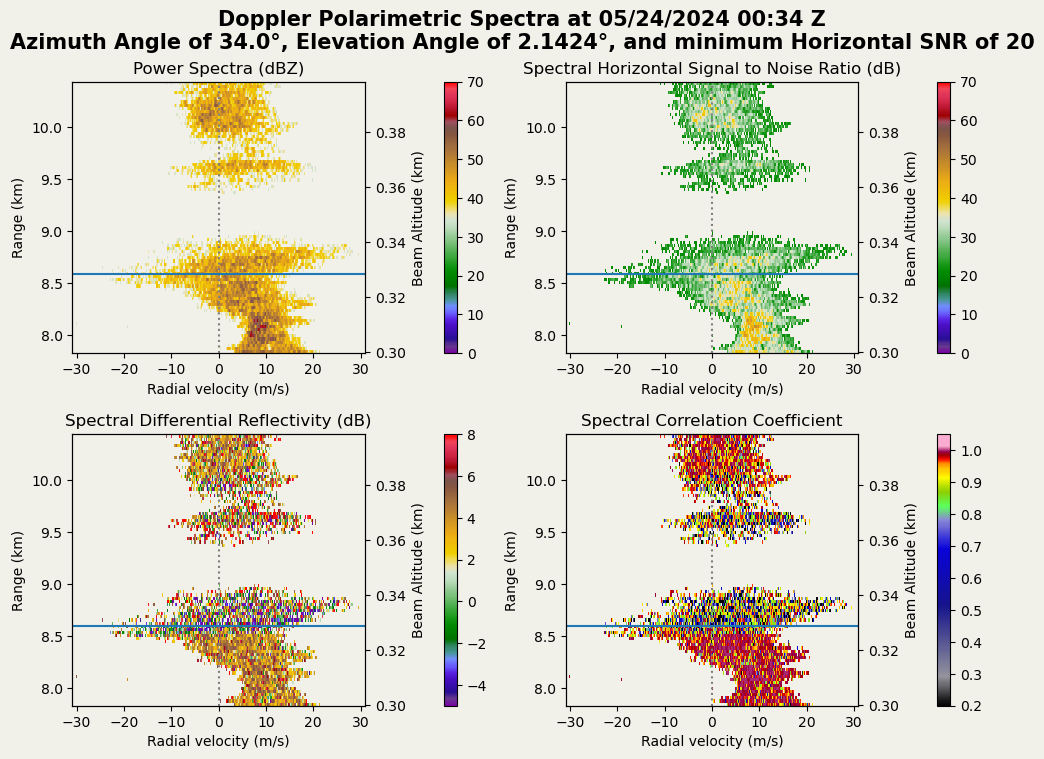

In [300]:
dpsd_fields = {
    'href': {
        'title': 'Power Spectra (dBZ)',
        'data': href,
        'ranges': (0, 70),
        'cmap': 'pyart_Carbone42',
    },
    'snrv': {
        'title': 'Spectral Horizontal Signal to Noise Ratio (dB)',
        'data': snrh,
        'ranges': (0, 70),
        'cmap': 'pyart_Carbone42',
    },
    'ZDR': {
        'title': 'Spectral Differential Reflectivity (dB)',
        'data': ZDR,
        'ranges': (-5, 8),
        'cmap': 'pyart_Carbone42',
    },
    'rhoHV': {
        'title': 'Spectral Correlation Coefficient',
        'data': rhoHV,
        'ranges': (0.2, 1.05),
        'cmap': radarIQ.viz.cmaps.rmap(256),
    }
}

ny, nx = snrh.shape

el_angle = radar.elevation['data'][spectrum_range['iaz']]
rad_ht_km = radar.altitude['data'][0]/1000
al_unique = np.sqrt((r_unique)**2 + ((4/3)*6371 + rad_ht_km)**2 + 2*r_unique*((4/3)*6371+rad_ht_km)*np.sin(np.radians(el_angle))) - (4/3)*6371

ir = np.argmin(np.abs(r_unique - r_single))
r_single = r_unique[ir]

fig = plt.figure(figsize=[12, 8])
for plot_num, field in enumerate(dpsd_fields.keys()):
    title = dpsd_fields[field]["title"]
    dpsd = dpsd_fields[field]['data']
    vmin, vmax = dpsd_fields[field]['ranges']
    cmap = dpsd_fields[field]['cmap']

    plt.subplot(2, 2, plot_num+1)
    plt.pcolormesh(x_axis, r_unique, dpsd, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.axvline(x=0, color='grey', linestyle=':')
    plt.title(title)
    plt.xlabel('Radial velocity (m/s)')
    plt.ylabel('Range (km)')
    plt.colorbar(pad=0.18)
    
    if line == 2:
        plt.axhline(y=r_single)
    
    plt.twinx()
    if np.mean(al_unique) < 0.1:
        plt.ylim([al_unique[0]*1000, al_unique[-1]*1000])
        plt.ylabel('Beam Altitude (m)')
    else:
        plt.ylim([al_unique[0], al_unique[-1]])
        plt.ylabel('Beam Altitude (km)')

plt.subplots_adjust(top=0.89, wspace=0.13, hspace=0.3)
plt.suptitle(
    'Doppler Polarimetric Spectra at ' + timeStr + '\n' +
    'Azimuth Angle of ' + str(az_vals[spectrum_range['iaz']]) + '°, Elevation Angle of ' +
    str(round(el_angle, 4)) + '°, and minimum Horizontal SNR of ' + str(maskval),
    weight='bold', fontsize=15
)
plt.savefig(imgDir/'spectrum.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

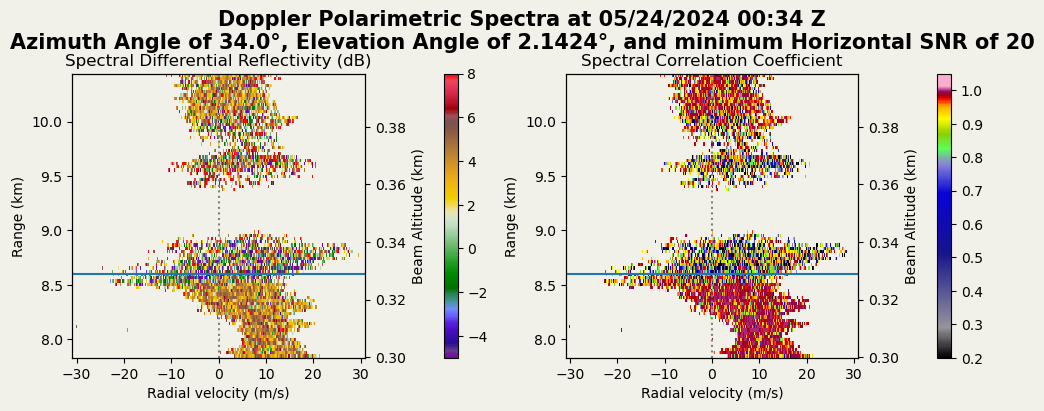

In [301]:
dpsd_fields = {
    'ZDR': {
        'title': 'Spectral Differential Reflectivity (dB)',
        'data': ZDR,
        'ranges': (-5, 8),
        'cmap': 'pyart_Carbone42',
    },
    'rhoHV': {
        'title': 'Spectral Correlation Coefficient',
        'data': rhoHV,
        'ranges': (0.2, 1.05),
        'cmap': radarIQ.viz.cmaps.rmap(256),
    }
}

fig = plt.figure(figsize=[12, 4])
for plot_num, field in enumerate(dpsd_fields.keys()):
    title = dpsd_fields[field]["title"]
    dpsd = dpsd_fields[field]['data']
    vmin, vmax = dpsd_fields[field]['ranges']
    cmap = dpsd_fields[field]['cmap']

    plt.subplot(1, 2, plot_num+1)
    plt.pcolormesh(x_axis, r_unique, dpsd, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.axvline(x=0, color='grey', linestyle=':')
    plt.title(title)
    plt.xlabel('Radial velocity (m/s)')
    plt.ylabel('Range (km)')
    plt.colorbar(pad=0.18)
    
    if line == 2:
        plt.axhline(y=r_single)
    
    plt.twinx()
    if np.mean(al_unique) < 0.1:
        plt.ylim([al_unique[0]*1000, al_unique[-1]*1000])
        plt.ylabel('Beam Altitude (m)')
    else:
        plt.ylim([al_unique[0], al_unique[-1]])
        plt.ylabel('Beam Altitude (km)')

plt.subplots_adjust(top=0.82, wspace=0.13, hspace=0.3)
plt.suptitle(
    'Doppler Polarimetric Spectra at ' + timeStr + '\n' +
    'Azimuth Angle of ' + str(az_vals[spectrum_range['iaz']]) + '°, Elevation Angle of ' +
    str(round(el_angle, 4)) + '°, and minimum Horizontal SNR of ' + str(maskval),
    weight='bold', fontsize=15
)
plt.savefig(imgDir/'polarSpectrum.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [302]:
from scipy.signal import savgol_filter

x_href = x_axis[~np.isnan(href[ir])]

#window = 20
window = len(x_href)//10

href1d = href[ir][~np.isnan(href[ir])]
href1d = savgol_filter(href1d, window, 2)

x_ZDR = x_axis[~np.isnan(ZDR[ir])]
ZDR1d = ZDR[ir][~np.isnan(ZDR[ir])]
#ZDR1d = savgol_filter(ZDR1d, window, 2)

x_rhoHV = x_axis[~np.isnan(rhoHV[ir])]
rhoHV1d = rhoHV[ir][~np.isnan(rhoHV[ir])]
rhoHV1d = savgol_filter(rhoHV1d, window, 2)

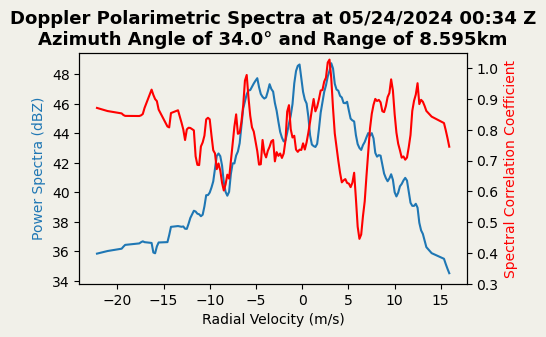

In [303]:
plt.figure(figsize=(5, 3))

plt.xlabel("Radial Velocity (m/s)")

plt.plot(x_href, href1d, color='#1f77b4')
plt.ylabel("Power Spectra (dBZ)", color='#1f77b4')

plt.twinx()
# plt.plot(x_ZDR, ZDR1d, color='r')
plt.plot(x_rhoHV, rhoHV1d, color='r')
plt.ylim([0.3,1.05])
plt.ylabel("Spectral Correlation Coefficient", color='r')

plt.title('Doppler Polarimetric Spectra at ' + timeStr + '\n' +
          'Azimuth Angle of ' + str(az_vals[spectrum_range['iaz']]) + '° and Range of ' +
           str(round(r_single, 4)) + 'km', weight='bold', fontsize=13)
plt.savefig(imgDir/'singlespectrum.png', dpi=600, bbox_inches='tight', transparent=True)